## Required Libraries and Helper Functions

In [29]:
import tensorflow as  tf
import numpy as np
import matplotlib.pyplot as  plt
from PIL import Image
from IPython.display import display

from tensorflow.python import keras
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.preprocessing.image import load_img,img_to_array
from tensorflow.python.keras.applications.vgg19 import preprocess_input
from tensorflow.python.keras.applications.vgg19 import VGG19 

%matplotlib inline

## Model

In [30]:
model = VGG19(
    include_top = False,
    weights = 'imagenet'
)

model.trainable = False
model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

 ## Image processing and Display

In [149]:
 def load_and_process_image(image_path):
        img = load_img(image_path,target_size=(300, 300))
        img = img_to_array(img)
        img = preprocess_input(img)
        img = np.expand_dims(img, axis=0)
        img = tf.convert_to_tensor(img)
        return img

In [150]:
def deprocess(x):
    #print(type(x))
    x[:,:,0] += 103.939
    x[:,:,1] += 116.779
    x[:,:,2] += 123.68
    x = x[:,:,::-1 ]  #BGR -> RGB
    
    x = np.clip(x ,0, 255).astype(np.uint8)
    return x

In [151]:
 def display_image(img):
        img = img.numpy()
        if len(img.shape) == 4:
            img = np.squeeze(img, axis=0)
            
        img = deprocess(img)
        
        display(Image.fromarray(img.astype(np.uint8), 'RGB'))
#         plt.grid(False)
#         plt.xticks([])
#         plt.yticks([])
#         plt.imshow(img);
        return 

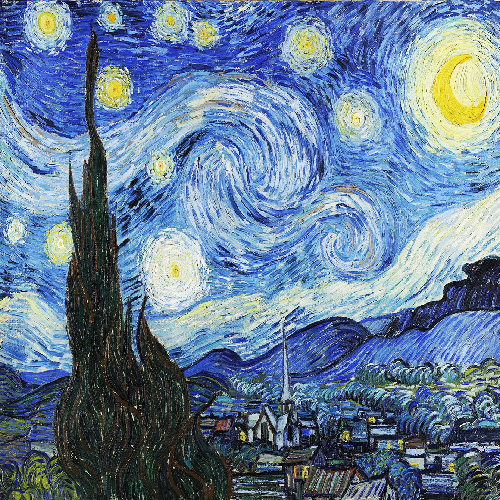

In [141]:
display_image(load_and_process_image('style2.jpg'))

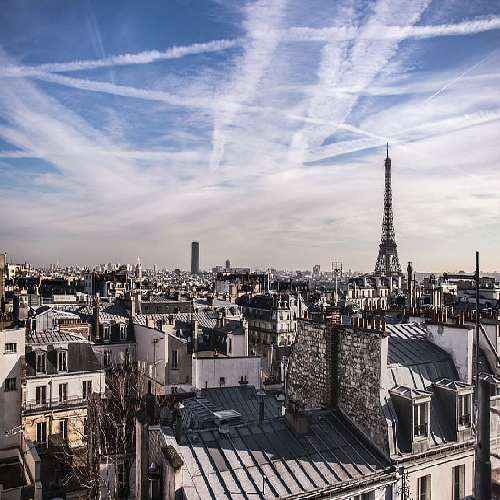

In [142]:
display_image(load_and_process_image('paris.jpg'))

 ## Content and Style Models

In [143]:
# change style and content layers  to see different results
content_layer = 'block5_conv2'

style_layers = [
    'block1_conv1',
    'block2_conv1',
    'block3_conv2',
    'block4_conv1',
    'block5_conv2'
]

content_model = Model(
    inputs = model.input,
    outputs = model.get_layer(content_layer).output
)

style_models = [Model(inputs = model.input,
                     outputs = model.get_layer(layer_name).output
                     )
                for layer_name in style_layers
               ]

## Loss

### Content Cost

In [144]:
def content_cost(content,generated):
    a_C = content_model(content)
    a_G = content_model(generated)
    cost = tf.reduce_mean(tf.square(a_C - a_G))
    return cost

### Gram Matrix

In [145]:
def gram_matrix(A):
    n_C = int(A.shape[-1])
    a = tf.reshape(A, [-1,n_C])
    n = tf.shape(a)[0]
    G = tf.matmul(a, a,transpose_a=True)
    return G/ tf.cast(n, tf.float32)

### Style Cost

In [146]:
def style_cost(style, generated, weight):
    J_style = 0
    i = 0
    for style_model in style_models:
        a_S = style_model(style)
        a_G = style_model(generated)
        GS = gram_matrix(a_S)
        GG = gram_matrix(a_G)
        current_cost = tf.reduce_mean(tf.square(GS-GG))
        if type(J_style) == list:
            J_style += current_cost*weight[i]
            i += 1
        else:
            J_style += current_cost*weight
            
        return J_style

## Training Loop

In [147]:
import time
def train(content_path, style_path, optimizer,
           weight,alpha=10., 
          beta=20., iteration_count=20):
    
    content = load_and_process_image(content_path)
    style = load_and_process_image(style_path)

    generated = tf.Variable(content, dtype = tf.float32)
    
    best_cost = 1e12 + 0.1
    best_image = None
    
    start_time = time.time()
    
    for i in range(iteration_count):  
        with tf.GradientTape() as tape:
            J_content = content_cost(content,generated)
            J_style = style_cost(style,generated,weight)
            J_total = alpha*J_content + beta*J_style
            
        grads = tape.gradient(J_total, generated)
        optimizer.apply_gradients([(grads,generated)])
        
        if J_total < best_cost:
            best_cost = J_total
            best_image = generated
                                              
        print("Cost at {}:{}, Time elapsed: {}".format(i,J_total,time.time()-start_time))
        generated_images.append(tf.identity(generated))
        
    return best_image

In [153]:
opt = tf.keras.optimizers.Adam(lr = 7.)
generated_images = []
best_image = train('paris.jpg','style4.jpg',opt,weight=0.2,iteration_count=100)

ResourceExhaustedError: OOM when allocating tensor with shape[1,3,300,300] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Conv2D]

## Plot the results

In [ ]:
display_image(best_image)

In [ ]:
display_image(generated_images[12])